In [1]:
%%time
###############################################################################
'''
Importing Libraries
'''
###############################################################################

import jax.numpy as jnp
from jax import jit ,lax
from jax import random

from jax import config
config.update("jax_enable_x64", True)

key = random.PRNGKey(42)

import numpy as np

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

from tqdm import tqdm

import jax

CPU times: user 1.65 s, sys: 214 ms, total: 1.86 s
Wall time: 1.78 s


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
fft = jnp.fft.rfftn
ifft = jnp.fft.irfftn

In [4]:
####################################################################################
'''
General definations and set-up
'''
####################################################################################
pi = np.pi

nu = 5e-3
# Size of the system

N = 2**5

Nf = int(N/2 + 1)

# tri-length of model
L = 2*pi

mesh = jnp.linspace(0, L, N, endpoint= False)

dx = mesh[1]-mesh[0]

X ,Y, Z = jnp.meshgrid(mesh,mesh,mesh,indexing = 'ij')

#Time step defination
dt = 5e-3

In [5]:
####################################################################################
'''
General definations and set-up for the spectral space
'''
####################################################################################

# The Fourier variables
kx , ky , kz  = jnp.meshgrid(jnp.fft.fftfreq(N, dx)*(2*pi),jnp.fft.fftfreq(N, dx)*(2*pi), jnp.fft.rfftfreq(N, dx)*(2*pi),indexing= 'ij')

k = jnp.stack([kx,ky,kz])

k2 = (k[0]**2 + k[1]**2 + k[2]**2)

sqrt_k2 = jnp.sqrt(k2)


####################################################################################
'''
Cut-off and Mask for Spectral method
'''
####################################################################################

alias_mask = jnp.where(np.round(sqrt_k2) <= N//3, 1, 0)

# alias_mask = (abs(k[0])<N//3)*(abs(k[1])<N//3)*(abs(k[2])<N//3)

k = k*alias_mask

k2 = k2*alias_mask

k_over_k2 = jnp.where(k2 == 0 , 0 ,  k/k2)*alias_mask

sqrt_k2 = alias_mask*sqrt_k2

shells = np.arange(-0.5, N//2 + 1 , 1.)
shells[0] = 0.


kvals = np.arange(0,N//2+1)

term_norm = 1/N**6
normalize = np.where( (k[2] == 0) + (k[2] == N//2) , term_norm ,2*term_norm)

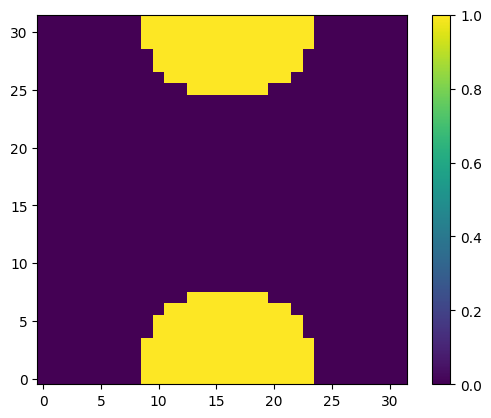

In [6]:
plt.imshow(jnp.fft.fftshift(1*alias_mask[:,:,7].T,1), origin = 'lower')
plt.colorbar()

In [7]:
def e3d_to_e1d(x):
  return np.histogram(sqrt_k2.ravel(),bins = shells,weights = x.ravel())[0]

In [8]:
@jit
def cross_func(a, b):

    return fft(jnp.stack([
        a[1]*b[2] - a[2]*b[1],
        a[2]*b[0] - a[0]*b[2],
        a[0]*b[1] - a[1]*b[0]]), axes=(1,2,3))



@jit
def curl_func(a, k = k ):

    return  ifft(jnp.stack([
        1j * (k[1] * a[2] - k[2] * a[1]),
        1j * (k[2] * a[0] - k[0] * a[2]),
        1j * (k[0] * a[1] - k[1] * a[0]) ]),axes=(1,2,3))

In [9]:
@jit
def RK4(U_hat):

  K1 = computeRHS(U_hat)
  K2 = computeRHS(U_hat + 0.5 * dt * K1)
  K3 = computeRHS(U_hat + 0.5 * dt * K2)
  K4 = computeRHS(U_hat + dt * K3)

  return U_hat + (dt / 6) * (K1 + 2*( K2 +  K3 )+ K4)

In [10]:
def dot(A):

  return (1j*(k[0]*A[0] + k[1]*A[1] + k[2]*A[2]))

In [11]:
@jit
def computeRHS(U_dumm):

  nonlinear_term = alias_mask*cross_func(ifft(U_dumm, axes=(1, 2, 3)), curl_func(U_dumm))

  return alias_mask*(nonlinear_term - jnp.einsum('ijkl,ijkl->jkl', nonlinear_term, k_over_k2)* k - nu * k2 * U_dumm)

In [12]:
@jit
def enstrophy(u_hat, kx = k[0], ky = k[1], kz = k[2]):

    omega_hat_sq = (
        jnp.abs(1j * (ky * u_hat[2] - kz * u_hat[1]))**2 +
        jnp.abs(1j * (kz * u_hat[0] - kx * u_hat[2]))**2 +
        jnp.abs(1j * (kx * u_hat[1] - ky * u_hat[0]))**2
    )

    return 0.5 * jnp.sum(omega_hat_sq)

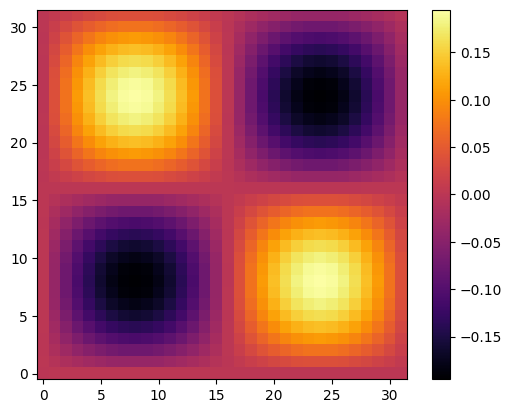

In [13]:
U = jnp.stack([jnp.sin(Y)*jnp.cos(X)*jnp.sin(Z),jnp.sin(X)*jnp.cos(Y) * jnp.sin(Z) ,-2*jnp.cos(Z)*jnp.sin(X)*jnp.sin(Y)])

# U = jnp.stack([jnp.cos(Y) + jnp.sin(Z),jnp.cos(Z) + jnp.sin(X) ,jnp.cos(X) + jnp.sin(Y)])

U_hat =  fft(U, axes=(1,2,3))

plt.imshow( ifft(U_hat[0])[-9,:,:].real, cmap = 'inferno', origin = 'lower')
plt.colorbar()

In [14]:
%%time

steps = 2000
E = np.zeros(int(steps))
w_k = np.zeros(int(steps))

for i in tqdm(range(steps)):

  U_hat = RK4(U_hat)
  ek = normalize*0.5*(jnp.abs(U_hat[0])**2 + jnp.abs(U_hat[1])**2 + jnp.abs(U_hat[2])**2)
  E[i] = jnp.sum(ek)
  w_k[i] = jnp.sum(jnp.arange(N//2 + 1)**2*e3d_to_e1d(ek))

100%|██████████| 2000/2000 [00:41<00:00, 48.07it/s]

CPU times: user 45.3 s, sys: 818 ms, total: 46.1 s
Wall time: 41.6 s


In [15]:
U_real = jnp.fft.irfftn(U_hat, axes=(1, 2, 3))
np.savez_compressed('u_5', U = U_real )

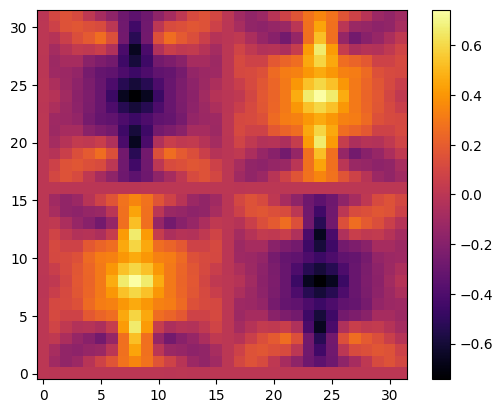

In [16]:
plt.imshow( ifft(U_hat[0])[0,:,:]  , origin = 'lower', cmap = 'inferno')
plt.colorbar()

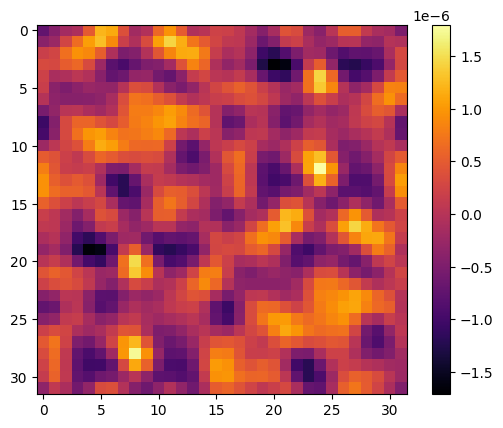

In [17]:
div_v = np.sum(U_hat*1j*k, axis = 0)
plt.imshow(ifft(div_v)[1], cmap = 'inferno')
plt.colorbar()

In [18]:
EE = np.array([5.91986022e-31, 4.35917697e-30, 1.14680443e+01, 7.39409692e+00,
       2.52513671e+00, 1.89771307e+00, 7.90280004e-01, 1.84294449e+00,
       7.33002083e-01, 7.45212015e-01, 6.95765339e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

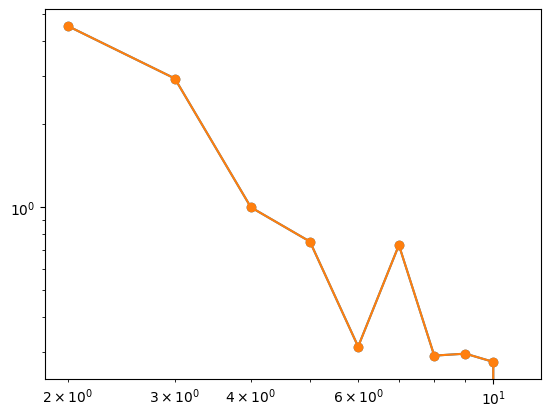

In [19]:
kvals = np.arange(0,N//2)

ek = normalize*0.5*(np.abs(U_hat[0])**2 + np.abs(U_hat[1])**2 + np.abs(U_hat[2])**2) #! This is the 3D ek array
E_k = e3d_to_e1d(ek)


plt.loglog(kvals[2:N//3+2],E_k[2:N//3+2]/E_k[4],'o-')

plt.loglog(kvals[2:N//3+2],EE[2:N//3+2]/EE[4],'o-')

In [21]:
W = np.array([372.0753201635978, 371.7346177873177, 371.8237790352298, 372.3335440391361, 373.2526105458943, 374.5682964556752, 376.2673559175817, 378.3368717606711, 380.76514214648654, 383.5424800740483, 386.66184880712524, 390.11926307818555, 393.9138961860182, 398.04785195089823, 402.5255952531825, 407.3530879287773, 412.53673703372306, 418.0823049786005, 423.99392995189226, 430.27335282854904, 436.91936419029, 443.92741256489205, 451.2892896263062, 458.99284201250043, 467.02173320690315, 475.35535291687705, 483.9690063554083, 492.83449100677717, 501.9210886044738, 511.1968909235069, 520.6302747798861, 530.1912765389135, 539.852609688649, 549.5901248131083, 559.3826179879056, 569.2110272730663, 579.0571868971895, 588.9024044204152, 598.726164473638, 608.5052335918681, 618.2133501927627, 627.8215529029623, 637.2990604590366, 646.6145015003038, 655.737231562213, 664.63848336003, 673.292172747716, 681.675304912447, 689.7680567577762, 697.5537104574151, 705.0186471603157, 712.1525677744944, 718.9490059736129, 725.4060755930194, 731.5272962815939, 737.322302298685, 742.8072690584032, 748.0049713044049, 752.9444773138563, 757.6605456848542, 762.192802812438, 766.5847455087825, 770.8825635655302, 775.1337478277828, 779.3854637210915, 783.6827253902866, 788.0664754642828, 792.5717259895504, 797.2259244352956, 802.0476740119626, 807.0458786022451, 812.2193253350226, 817.5566813707497, 823.0368699225726, 828.6297934687193, 834.2973717457489, 839.994843356735, 845.6722390434265, 851.2758839953926, 856.7497513505593, 862.0364977828824, 867.0780815701705, 871.8159857558471, 876.1912076278068, 880.1442770094093, 883.6155815001418, 886.5461888524476, 888.8791914872631, 890.5614203470434, 891.5452615654533, 891.7903126913955, 891.2647356488964, 889.9463425764786, 887.8235936452136, 884.8967070821484, 881.1789496105632, 876.6979364764859, 871.4965328476516, 865.6328353328995, 859.1788011179949, 852.2173751607523, 844.8383507043718, 837.1335477781782, 829.1920847837124, 821.096488807568, 812.9201611545379, 804.7263709266583, 796.5686028175828, 788.4918317781177, 780.5341892589023, 772.7285245911253, 765.1035117781691, 757.6841482786643, 750.4916817474323, 743.5431427390886, 736.8507369162954, 730.4213589684181, 724.2564441072802, 718.3522890021693, 712.7008706014158, 707.2910859223103, 702.1102452451714, 697.145591030823, 692.385598568245, 687.8208491558453, 683.4443499514288, 679.2512918837051, 675.2383630692927, 671.4028399368487, 667.7417347156284, 664.2512697733617, 660.9268752945873, 657.7637810903831, 654.7581220699949, 651.9083332166326, 649.2165082146037, 646.6893653424283, 644.3385209637803, 642.1799099600097, 640.2323833326371, 638.5157039326375, 637.0482925753364, 635.8451037769611, 634.9159225497303, 634.2642033586666, 633.8863848816075, 633.7714832798732, 633.9007441514169, 634.2472274095953, 634.7753705980413, 635.4407532604359, 636.1903930268697, 636.9638936489744, 637.6956303501925, 638.3179364715734, 638.7650134811737, 638.9770937675819, 638.9042932523882, 638.5096179653236, 637.7707221014255, 636.680218040384, 635.2445645521286, 633.4817635055522, 631.4182443929093, 629.0853915153879, 626.5161677891856, 623.742221998768, 620.7917523449557, 617.6882622032429, 614.4502077701381, 611.0914212156306, 607.6221099766701, 604.0501885720851, 600.3826930391599, 596.6270543432835, 592.7920576685119, 588.8883799317372, 584.9286686602688, 580.9271926578349, 576.8991509990077, 572.8597659607681, 568.8233039837114, 564.8021658825692, 560.8061654048857, 556.8420785527039, 552.913501342518, 549.0210081440612, 545.1625632192411, 541.3341098486923, 537.5302474455441, 533.7449076532021, 529.9719535195525, 526.205647553781, 522.4409600467762, 518.6737138272548, 514.9005819555216, 511.1189685547665, 507.3268095367514, 503.52233031435645, 499.7037935504759, 495.8692637072136])

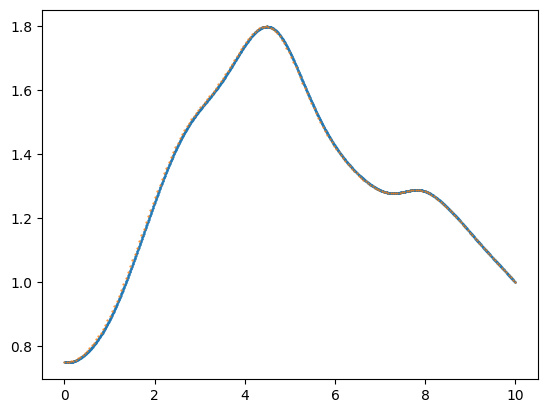

In [40]:
a_anikat = np.linspace(0,10,2000)
a_raj = np.linspace(0,10,200)
plt.plot(a_anikat,1*w_k/w_k[-1], '.', ms = 1 )

plt.plot(a_raj,W[1:]/W[-1], '.', ms = 1 )

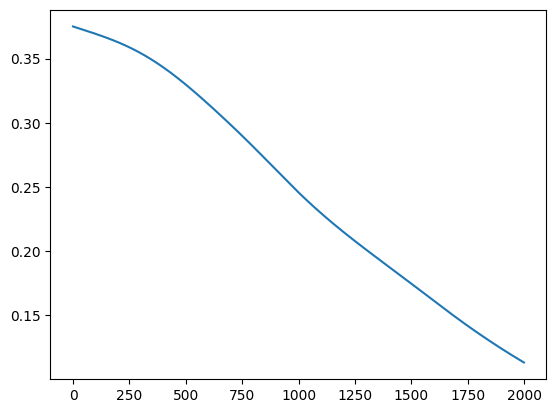

In [24]:
plt.plot(E)

In [25]:
shells= jnp.arange(-0.5,N//2+1 + 1,1)

k_whole  = jnp.stack(jnp.meshgrid(jnp.fft.fftfreq(N, dx)*(2*pi),jnp.fft.fftfreq(N, dx)*(2*pi), jnp.fft.fftfreq(N, dx)*(2*pi),indexing= 'ij'))

k2_whole = (k_whole[0]**2 + k_whole[1]**2 + k_whole[2]**2)

sqrt_k2_whole = jnp.sqrt(k2_whole)


In [26]:
def compute_energy_transfer(u_hat,K_min,K_max , Q_min, Q_max ,sqrt_k2 = sqrt_k2_whole,k_whole = k_whole, shells = shells):

  u = jnp.fft.irfftn(u_hat, axes=(1, 2, 3))

  u_hat = jnp.fft.fftn(u, axes=(1, 2, 3))

  mask_K = np.where((sqrt_k2_whole >= K_min),1 ,0)*np.where((sqrt_k2_whole <= K_max) ,1 ,0)

  u_K = jnp.fft.ifftn(u_hat*mask_K, axes = (1,2,3))

  mask_Q = np.where((sqrt_k2_whole >= Q_min),1 ,0)*np.where((sqrt_k2_whole <= Q_max) ,1 ,0)

  u_Q = u_hat*mask_Q

  u_tensor = jnp.fft.ifftn(jnp.einsum('ijkl,mjkl -> imjkl',1j*k_whole,u_Q),axes = (2,3,4))

  transfer = jnp.sum(u_K*jnp.einsum('ijkl , imjkl -> mjkl', u,u_tensor))

  return transfer

In [27]:
@jit
def compute_energy_flux(u_hat, K_cut, k_whole = k_whole, sqrt_k2_whole = sqrt_k2_whole):
    u = jnp.fft.irfftn(u_hat, axes=(1, 2, 3))  # shape: (3, Nx, Ny, Nz)

    u_hat_full = jnp.fft.fftn(u, axes=(1, 2, 3))  # shape: (3, Nx, Ny, Nz)

    grad_u_hat = 1j * k_whole[:, None] * u_hat_full[None, :, ...]  # shape: (3,3,Nx,Ny,Nz)
    grad_u = jnp.fft.ifftn(grad_u_hat, axes=(2, 3, 4))  # shape: (3,3,Nx,Ny,Nz)

    adv_term = jnp.einsum('i...,ij...->j...', u, grad_u)

    mask_lp = (sqrt_k2_whole <= K_cut).astype(u_hat.dtype)

    u_lp = jnp.fft.ifftn(u_hat_full * mask_lp, axes=(1, 2, 3))  # shape: (3,Nx,Ny,Nz)

    flux = jnp.sum(jnp.real(u_lp * adv_term))

    return flux


In [28]:
def shell_by_shell_fluxes(u_hat, shells= shells , sqrt_k2= sqrt_k2, sqrt_k2_whole= sqrt_k2_whole, k_whole= k_whole):

    u = jnp.fft.irfftn(u_hat, axes=(1, 2, 3))
    u_hat = jnp.fft.fftn(u, axes=(1, 2, 3))

    dumm_field = 0

    for i in range(1, len(shells)):
        # Create binary mask
        mask_K = jnp.logical_and(
            sqrt_k2_whole >= shells[i - 1],
            sqrt_k2_whole <= shells[i]
        )*1.0

        # Apply mask
        u_K = u_hat * mask_K

        # Compute flux contribution and accumulate
        flux_term = jnp.fft.ifftn(jnp.sum(u_K * 1j * k_whole, axis=0), axes=(0, 1, 2))
        dumm_field += flux_term

    return dumm_field

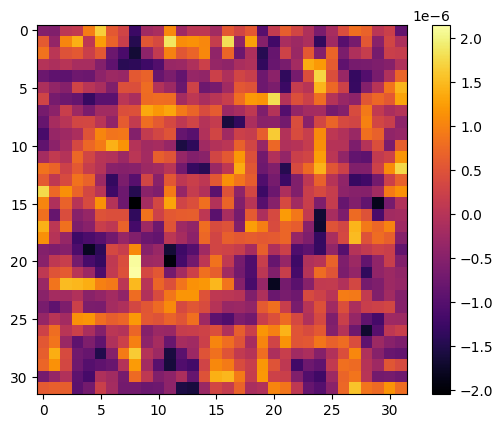

In [29]:
a = shell_by_shell_fluxes(U_hat)
plt.imshow(a[1].real, cmap = 'inferno')
plt.colorbar()

In [30]:
def compute_flux_spectrum(u_hat, k_bins, k_whole = k_whole , sqrt_k2_whole = sqrt_k2_whole):
    return jnp.array([compute_energy_flux(u_hat, K, k_whole, sqrt_k2_whole) for K in k_bins])

In [31]:
PI_K = compute_flux_spectrum(U_hat , kvals)

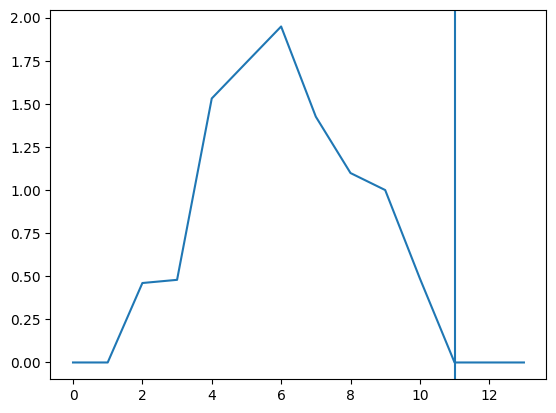

In [41]:
plt.plot(kvals[:14],PI_K[:14]/PI_K[9])
plt.axvline(11)

In [34]:
np.savez_compressed('u_RAJ', U = U_real )